In [ ]:
!git clone https://github.com/MarcoForte/FBA-Matting.git
%cd FBA-Matting

fatal: destination path 'FBA-Matting' already exists and is not an empty directory.
/content/FBA-Matting


**Получаем TRIMAP**

In [ ]:
CLASS_MAP = {"background": 0, "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5, "bus": 6, "car": 7,
             "cat": 8, "chair": 9, "cow": 10, "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
             "potted plant": 16, "sheep": 17, "sofa": 18, "train": 19, "tv/monitor": 20}

In [ ]:
target_class = 'cat'
conf_threshold = 0.7

In [ ]:
import os
import argparse
import torch
import numpy as np
from torchvision import transforms
import cv2

from PIL import Image
from io import BytesIO
from six.moves import urllib

import matplotlib.pyplot as plt

In [ ]:
def trimap(probs, size, conf_threshold):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [3]: an image with probabilities of each pixel being the foreground, size of dilation kernel,
    foreground confidence threshold
    Output    : a trimap
    """
    mask = (probs > 0.05).astype(np.uint8) * 255

    pixels = 2 * size + 1
    kernel = np.ones((pixels, pixels), np.uint8)

    dilation = cv2.dilate(mask, kernel, iterations=1)

    remake = np.zeros_like(mask)
    remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
    remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.

    return remake

In [ ]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()
print('loaded')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


loaded


In [ ]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://funart.pro/uploads/posts/2021-07/1626857468_3-funart-pro-p-sibirskaya-koshka-serebristaya-zhivotnie-k-3.jpg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
f = urllib.request.urlopen(image_url)
jpeg_str = f.read()
input_image = np.array(Image.open(BytesIO(jpeg_str)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


True

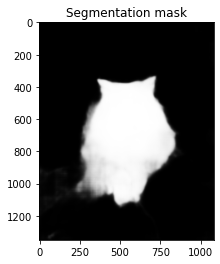

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

with torch.no_grad():
    output = model(input_batch)['out'][0]
    output = torch.softmax(output, 0)

output_cat = output[CLASS_MAP[target_class], ...].numpy()
plt.title('Segmentation mask')
plt.imshow(output_cat, cmap='gray', vmin=0, vmax=1)

trimap_image = trimap(output_cat, 7, conf_threshold)
cv2.imwrite('trimap.png', trimap_image)
cv2.imwrite('image.png', input_image)

**Подгружаем модель**

In [ ]:
from demo import np_to_torch, pred, scale_input
from dataloader import read_image, read_trimap
from networks.models import build_model

In [ ]:
!gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
model = build_model('FBA.pth').cuda()

Downloading...
From: https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
To: /content/FBA-Matting/FBA.pth
100% 139M/139M [00:00<00:00, 157MB/s]
modifying input layer to accept 11 channels


In [ ]:
image = read_image('image.png')
trimap = read_trimap('trimap.png')

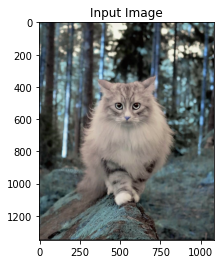

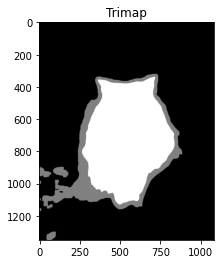

In [ ]:
plt.title('Input Image')
plt.imshow(image)
plt.show()

# transform two channel trimap back to single channel
trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

In [ ]:
fg, bg, alpha = pred(image, trimap, model)

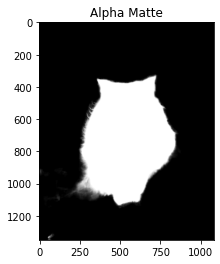

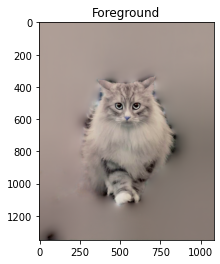

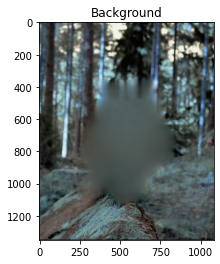

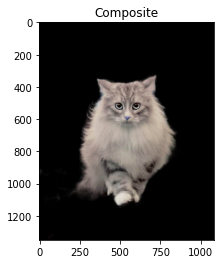

In [ ]:
plt.title('Alpha Matte')
plt.imshow(alpha, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.title('Foreground')
plt.imshow(fg)
plt.show()
plt.title('Background')
plt.imshow(bg)
plt.show()
plt.title('Composite')
plt.imshow(fg*alpha[:,:,None])
plt.show()

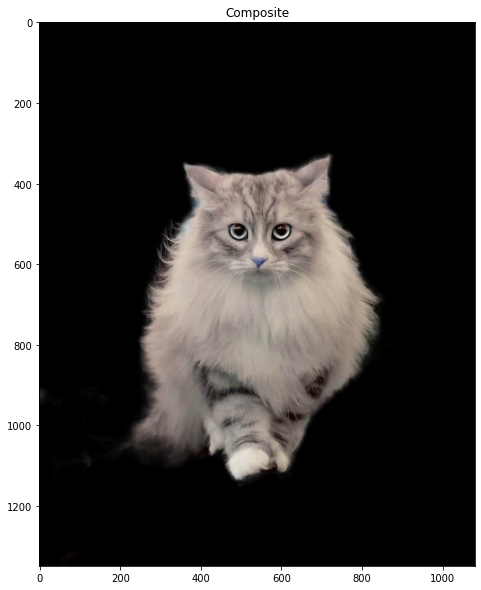

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Composite')
plt.imshow(fg*alpha[:,:,None])
plt.show()